In [1]:
from __future__ import print_function

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import nltk
import numpy as np


import pandas as pd
import random


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from nltk import pos_tag
from nltk.stem import PorterStemmer

In [2]:
def preprocessing(text):
    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())

    tokens = [word for sent in nltk.sent_tokenize(text2) for word in
              nltk.word_tokenize(sent)]
    
    tokens = [word.lower() for word in tokens]
    
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    
    tokens = [word for word in tokens if len(word)>=3]
    
    stemmer = PorterStemmer()#어간, 접사 날리기 
    tokens = [stemmer.stem(word) for word in tokens]

    tagged_corpus = pos_tag(tokens)    
    
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']

    lemmatizer = WordNetLemmatizer()#원형 복원

    def prat_lemmatize(token,tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token,'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token,'v')
        else:
            return lemmatizer.lemmatize(token,'n')
    
    pre_proc_text =  " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])             

    return pre_proc_text

In [13]:
!pwd

/Users/anseon-yeong/수업/2021-2/텍스트정보처리/week12


In [14]:
lines = []


fin = open("./alice_in_wonderland.txt", "rb")


for line in fin:
    line = line.strip().decode("ascii", "ignore")
    
    if len(line) == 0:
        continue
    lines.append(preprocessing(line))
fin.close()

In [15]:
#단어를 인덱스에, 인덱스를 단어에 매핑하는 딕셔너리를 만든다.
#모델은 문자,단어 입력에 대해 작동하지 않는다
#고로 단어를 숫자로 변환하고 신경망 모델을 사용해 계산 수행 후 단어로 적용해야함 

import collections
counter = collections.Counter()

for line in lines:
    for word in nltk.word_tokenize(line):
        counter[word.lower()]+=1

word2idx = {w:(i+1) for i,(w,_) in enumerate(counter.most_common())}#데이터 수가 많은 순으로 정렬         
idx2word = {v:k for k,v in word2idx.items()}

In [16]:

xs = []
ys = []

for line in lines:
    embedding = [word2idx[w.lower()] for w in nltk.word_tokenize(line)] 
    triples = list(nltk.trigrams(embedding))#트라이그램 추출
    w_lefts = [x[0] for x in triples]
    w_centers = [x[1] for x in triples]
    w_rights = [x[2] for x in triples]
    xs.extend(w_centers)
    ys.extend(w_lefts)
    xs.extend(w_centers)
    ys.extend(w_rights)
          
print (len(word2idx))#딕셔너리 길이가 어휘의 크기 


1786


In [17]:
pip install nltk==3.4

     |████████████████████████████████| 1.4 MB 7.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4-py3-none-any.whl size=1436379 sha256=ffba16efbedf7074f40b07560ce774bad074d3ff279728b262f891ad2beb209e
  Stored in directory: /Users/anseon-yeong/Library/Caches/pip/wheels/e3/8d/39/e3aa34880de366c8b3e4584c4f5f3777289005a4b1553a9c4c
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.5
    Uninstalling nltk-3.5:
      Successfully uninstalled nltk-3.5
Note: you may need to restart the kernel to use updated packages.


In [20]:
#신경망 모델은 입력 및 출력 변수를 벡터공간에 매핑한다. 


vocab_size = len(word2idx)+1

ohe = OneHotEncoder(categories=[range(vocab_size)])
X = ohe.fit_transform(np.array(xs).reshape(-1, 1)).todense()
Y = ohe.fit_transform(np.array(ys).reshape(-1, 1)).todense()
Xtrain, Xtest, Ytrain, Ytest,xstr,xsts = train_test_split(X, Y,xs, test_size=0.3,
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)


(9707, 1787) (4161, 1787) (9707, 1787) (4161, 1787)


In [21]:
# 초기에는 모든 입력 단어의 크기가 압축돼 출력 형식을 얻는다.
# 두 번째 레이어에서 차원이 2차원으로 축소된다. 
# 모델을 학습한 후 테스트 데이터에 대한 예측을 위해 두 번째 레이어까지 추출


from keras.layers import Input,Dense,Dropout
from keras.models import Model

np.random.seed(42)

BATCH_SIZE = 128
NUM_EPOCHS = 20


input_layer = Input(shape = (Xtrain.shape[1],),name="input")
first_layer = Dense(300,activation='relu',name = "first")(input_layer)
first_dropout = Dropout(0.5,name="firstdout")(first_layer)

second_layer = Dense(2,activation='relu',name="second")(first_dropout)

third_layer = Dense(300,activation='relu',name="third")(second_layer)
third_dropout = Dropout(0.5,name="thirdout")(third_layer)

fourth_layer = Dense(Ytrain.shape[1],activation='softmax',name = "fourth")(third_dropout)


history = Model(input_layer,fourth_layer)
history.compile(optimizer = "rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

history.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,epochs=NUM_EPOCHS, verbose=1,validation_split = 0.2)


Epoch 1/20
61/61 [==============================] - 2s 15ms/step - loss: 7.2272 - accuracy: 0.0338 - val_loss: 6.4239 - val_accuracy: 0.0479
Epoch 2/20
61/61 [==============================] - 1s 12ms/step - loss: 6.3628 - accuracy: 0.0445 - val_loss: 6.4408 - val_accuracy: 0.0479
Epoch 3/20
61/61 [==============================] - 1s 12ms/step - loss: 6.3620 - accuracy: 0.0418 - val_loss: 6.4717 - val_accuracy: 0.0479
Epoch 4/20
61/61 [==============================] - 1s 12ms/step - loss: 6.3287 - accuracy: 0.0428 - val_loss: 6.5009 - val_accuracy: 0.0479
Epoch 5/20
61/61 [==============================] - 1s 12ms/step - loss: 6.3042 - accuracy: 0.0397 - val_loss: 6.5263 - val_accuracy: 0.0479
Epoch 6/20
61/61 [==============================] - 1s 11ms/step - loss: 6.2884 - accuracy: 0.0431 - val_loss: 6.5404 - val_accuracy: 0.0479
Epoch 7/20
61/61 [==============================] - 1s 12ms/step - loss: 6.2854 - accuracy: 0.0433 - val_loss: 6.5472 - val_accuracy: 0.0479
Epoch 8/20
61

In [22]:
# 잠재 변수 예측을 위해 모델의 인코더 부분 추출
encoder = Model(history.input,history.get_layer("second").output)

# 추출된 인코더 모델을 사용해 잠재 변수 예측 
reduced_X = encoder.predict(Xtest)


# 더 나은 표현을 위해 출력을 pandas 데이터프레임 구조로 변환
final_pdframe = pd.DataFrame(reduced_X)
final_pdframe.columns = ["xaxis","yaxis"]
final_pdframe["word_indx"] = xsts
final_pdframe["word"] = final_pdframe["word_indx"].map(idx2word)


In [28]:
rows = random.sample(list(final_pdframe.index), 100)
vis_df = final_pdframe.loc[rows]

labels = list(vis_df["word"])
xvals = list(vis_df["xaxis"])
yvals = list(vis_df["yaxis"])

In [29]:
final_pdframe

,xaxis,yaxis,word_indx,word
0,0.357401,0.766126,38,must
1,0.175181,0.642460,246,box
2,0.570211,0.653156,168,notic
3,0.054361,0.746939,7,look
4,0.000000,0.596326,248,play
...,...,...,...,...
4156,0.375885,0.677578,14,see
4157,0.793072,0.037330,2,alic
4158,0.731258,0.298528,183,mouth
4159,0.278128,0.274577,17,time


In [30]:
vis_df

,xaxis,yaxis,word_indx,word
2621,0.350075,0.412809,171,answer
1674,0.000000,0.176806,364,golden
2173,0.516922,0.292892,423,violent
3968,0.719941,0.391762,134,curiou
2374,0.382511,0.758436,5,think
...,...,...,...,...
1924,0.587109,0.384063,45,back
2199,0.671093,0.817791,241,glad
1835,0.278128,0.274577,17,time
748,0.734069,0.108360,50,white


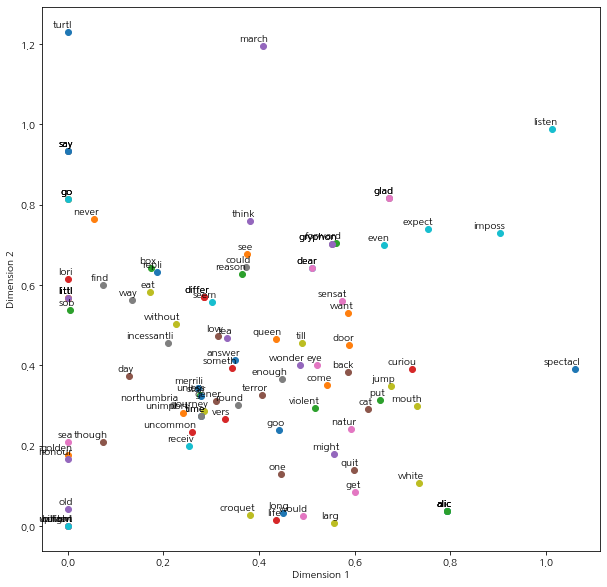

In [31]:
#in inches
plt.figure(figsize=(10, 10))  

for i, label in enumerate(labels):
    x = xvals[i]
    y = yvals[i]
    plt.scatter(x, y)
    plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',
                 ha='right',va='bottom')

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()